In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import important libraries

In [35]:
!pip install dill

In [36]:
import pandas as pd
import numpy as np
import dill
from sklearn.utils import shuffle

# Read train data

In [37]:
X_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_train_preprocessed_under')
y_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_train_preprocessed_under')['target_event']

# Load test pipline

In [38]:
with open('/content/drive/MyDrive/Churn Prediction/test_pipeline.pkl', 'rb') as f:
    test_pipeline = dill.load(f)

# Read test data and transform

In [39]:
X_test = test_pipeline.transform(pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_test'))
y_test = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_test')['target_event']

# Binary evaluation class

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

In [41]:
class BinaryClassificationEvaluation:
    def __init__(self, y_test, y_pred, y_pred_prob=None):
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_prob = y_pred_prob

    def accuracy(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        return accuracy

    def classification_report(self):
        report = classification_report(self.y_test, self.y_pred)
        return report

    def precision_recall_f1(self):
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        return precision, recall, f1
    def roc_score(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for ROC curve evaluation.")
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        return auc_score

    def visualize_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Churn', 'Churn'],
                    yticklabels=['Not Churn', 'Churn'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def roc_curve_visualization(self):
        auc_score = self.roc_score()
        print('=========================')
        print('||','ROC AUC Score:', auc_score.round(2),'||')
        print('=========================')
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_prob)
        plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def precision_recall_curve_plot(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for Precision-Recall curve evaluation.")

        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_prob)
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

---
# ***Random Forest Classifier Model***
---

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Initialize the random forest moel

In [43]:
random_forest = RandomForestClassifier(random_state=42, bootstrap=True, oob_score=True)

# Initialize stratifiedkfold

In [44]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# using grid search find best parameters and best splits using stratifiedkfold

In [55]:
params = {
    'max_depth': [30, 35],
    'n_estimators': [300, 350]
}

forest_search = GridSearchCV(estimator=random_forest,
                             param_grid=params, cv=kfold, scoring='f1', n_jobs=2)

# Fit the training data

In [56]:
forest_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [30, 35], 'n_estimators': [300, 350]},
             scoring='f1')

# Random forest evaluation class

In [47]:
best_forest = forest_search.best_estimator_

In [48]:
print('Best Parameters:', forest_search.best_params_)
print('Best Score:', forest_search.best_score_)

Best Parameters: {'max_depth': 30, 'n_estimators': 300}
Best Score: 0.7830097311303327


In [49]:
rand_forest_eval = BinaryClassificationEvaluation(y_test, best_forest.predict(X_test), forest_search.predict_proba(X_test)[:, 1])

# Evaluate model from different corner

In [50]:
print(rand_forest_eval.classification_report())

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     15296
           1       0.72      0.74      0.73      7226

    accuracy                           0.82     22522
   macro avg       0.80      0.80      0.80     22522
weighted avg       0.83      0.82      0.83     22522



In [51]:
precision, recall, f1 = rand_forest_eval.precision_recall_f1()
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.72
Recall: 0.74
F1 Score: 0.73


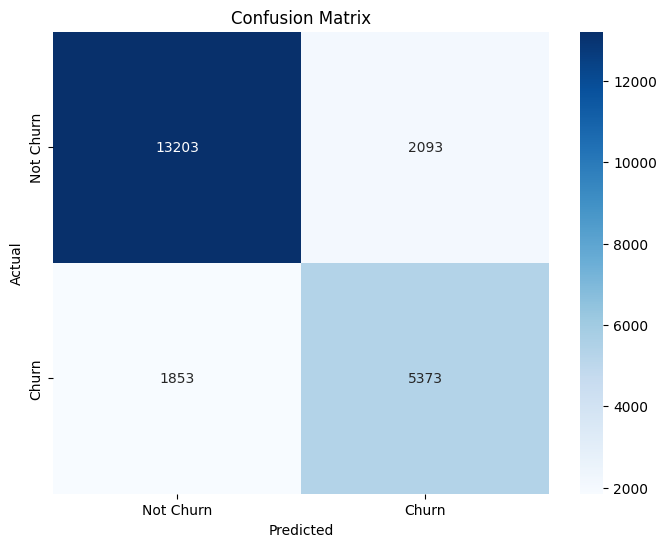

In [52]:
rand_forest_eval.visualize_confusion_matrix()

|| ROC AUC Score: 0.88 ||


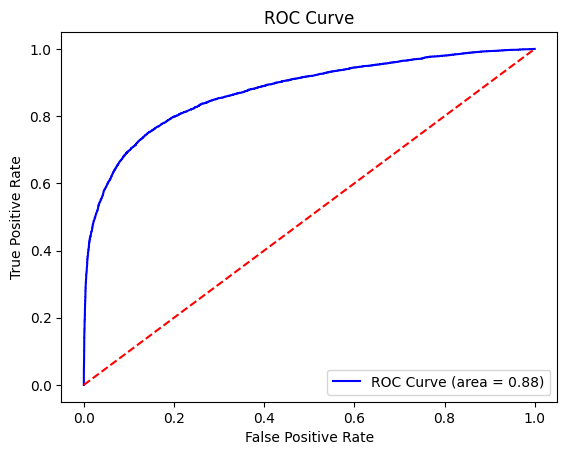

In [53]:
rand_forest_eval.roc_curve_visualization()

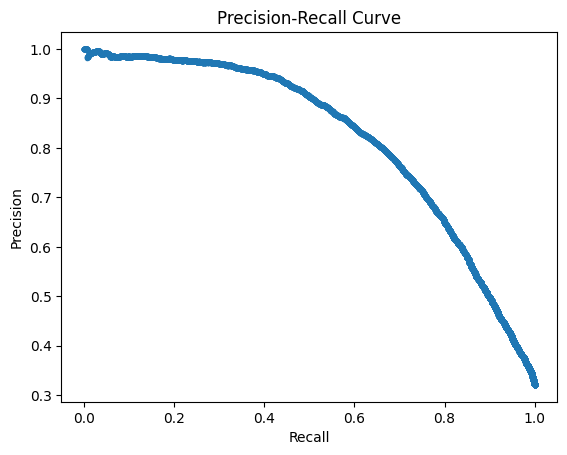

In [54]:
rand_forest_eval.precision_recall_curve_plot()

# Try different decision threshold to increase performance

In [79]:
threshold = 0.55
y_pred_binary = (forest_search.predict_proba(X_test)[:, 1] >= threshold).astype(int)

In [80]:
new_thresh_eval = BinaryClassificationEvaluation(y_test, y_pred_binary, forest_search.predict_proba(X_test)[:, 1])

# Choose 0.55 as decision threshold because it showed best precision/recall traid-off

In [81]:
print(new_thresh_eval.classification_report())

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     15296
           1       0.77      0.69      0.73      7226

    accuracy                           0.84     22522
   macro avg       0.82      0.80      0.81     22522
weighted avg       0.83      0.84      0.83     22522



In [82]:
print(rand_forest_eval.classification_report())

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     15296
           1       0.72      0.74      0.73      7226

    accuracy                           0.82     22522
   macro avg       0.80      0.80      0.80     22522
weighted avg       0.83      0.82      0.83     22522



# Create custom class for random forest classifier

In [83]:
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib

In [88]:
class RandomForestCustom(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth = 30, n_estimators = 300, threshold=0.5):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.threshold = threshold
        self.model = None

    def fit(self, X, y):
        self.model = RandomForestClassifier(
            max_depth=self.max_depth,
            n_estimators=self.n_estimators,
            random_state=42
        )
        self.model.fit(X, y)

    def predict(self, X):
        if self.model is None:
            raise ValueError("Model must be fitted before making predictions.")

        decision_func = self.model.predict_proba(X)[:, 1]
        y_pred = (decision_func >= self.threshold).astype(int)
        return y_pred

    def predict_proba(self, X):
        if self.model is None:
            raise ValueError("Model must be fitted before making predictions.")
        return self.model.predict_proba(X)

    def set_threshold(self, new_threshold):
        self.threshold = new_threshold

    def get_threshold(self):
        return self.threshold

    def save_model(self, file_path):
        with open(file_path, 'wb') as file:
            dill.dump(self, file)

In [89]:
best_params = forest_search.best_params_
best_index = np.argmax(forest_search.cv_results_['mean_test_score'])

forest_thesh = RandomForestCustom(
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    threshold=0.55
)

forest_thesh.fit(X_train, y_train)

In [90]:
final_forest_eval = BinaryClassificationEvaluation(y_test, forest_thesh.predict(X_test), forest_thesh.predict_proba(X_test)[:, 1])

In [91]:
print(final_forest_eval.classification_report())

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     15296
           1       0.77      0.69      0.73      7226

    accuracy                           0.84     22522
   macro avg       0.82      0.80      0.81     22522
weighted avg       0.83      0.84      0.83     22522



# Save the model

In [92]:
forest_thesh.save_model('/content/drive/MyDrive/Churn Prediction/random_forest_churn.pkl')

---
# ***Extra Trees Classifier Model***
---

In [93]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize ExtraTreeClassifier

In [94]:
extra_tree = ExtraTreesClassifier(random_state=42, bootstrap=True, oob_score=True)

# Using grid search find best parameters and best splits using stratifiedkfold

In [95]:
extra_params = {
    'max_depth': [30, 35],
    'n_estimators': [300, 350]
}

extra_search = GridSearchCV(estimator=extra_tree,
                            param_grid=extra_params,
                            cv=kfold,
                            scoring='f1', n_jobs=2)

In [96]:
extra_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=ExtraTreesClassifier(bootstrap=True, oob_score=True,
                                            random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [30, 35], 'n_estimators': [300, 350]},
             scoring='f1')

In [97]:
best_params = extra_search.best_params_
best_model = extra_search.best_estimator_

# Extra tree evaluation object creation

In [98]:
extra_eval = BinaryClassificationEvaluation(y_test, extra_search.predict(X_test), extra_search.predict_proba(X_test)[:, 1])

# Evaluate extra tree performance from different

In [101]:
print(extra_eval.classification_report())

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     15296
           1       0.72      0.74      0.73      7226

    accuracy                           0.82     22522
   macro avg       0.80      0.80      0.80     22522
weighted avg       0.83      0.82      0.82     22522



In [102]:
precision, recall, f1 = extra_eval.precision_recall_f1()
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.72
Recall: 0.74
F1 Score: 0.73


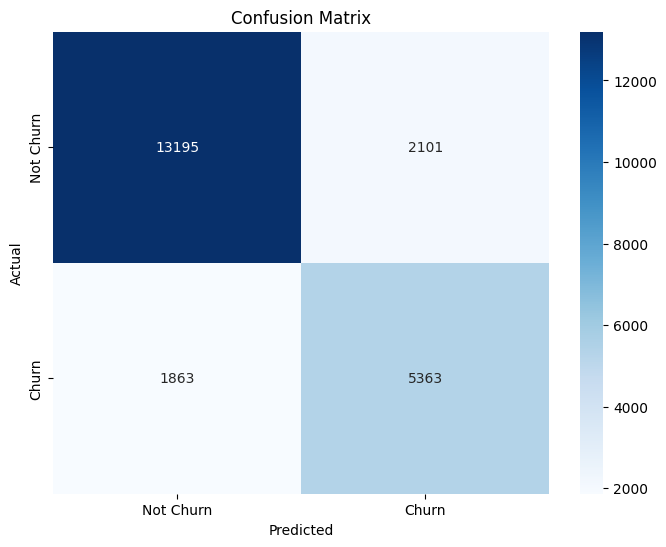

In [103]:
extra_eval.visualize_confusion_matrix()

|| ROC AUC Score: 0.88 ||


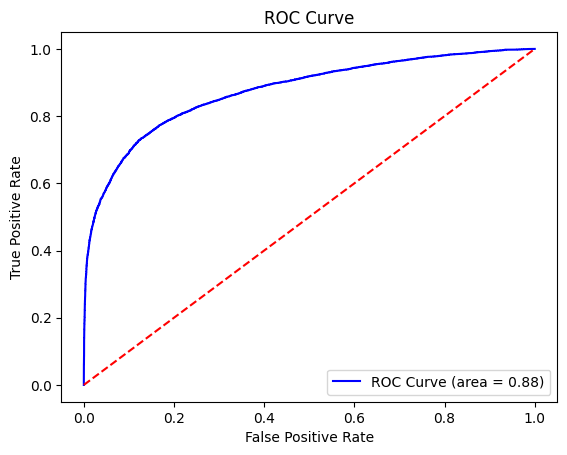

In [104]:
extra_eval.roc_curve_visualization()

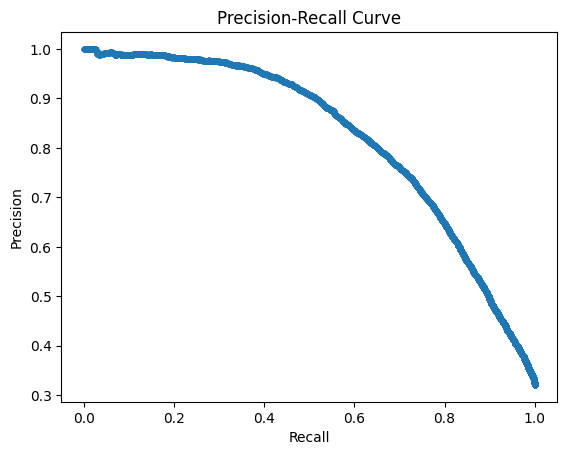

In [105]:
extra_eval.precision_recall_curve_plot()

# Try different decision threshold to increase performance

In [133]:
extra_thresh = 0.535
y_pred_binary = (extra_search.predict_proba(X_test)[:, 1] >= extra_thresh).astype(int)

In [134]:
extra_thresh_eval = BinaryClassificationEvaluation(y_test, y_pred_binary, extra_search.predict_proba(X_test)[:, 1])

# Performance of ExtraTreeClassifier

In [135]:
print(extra_thresh_eval.classification_report())

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     15296
           1       0.77      0.69      0.73      7226

    accuracy                           0.83     22522
   macro avg       0.81      0.80      0.80     22522
weighted avg       0.83      0.83      0.83     22522



# Performance of RandomForestClassifier

In [136]:
print(new_thresh_eval.classification_report())

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     15296
           1       0.77      0.69      0.73      7226

    accuracy                           0.84     22522
   macro avg       0.82      0.80      0.81     22522
weighted avg       0.83      0.84      0.83     22522



---
# ***Summury: I save only random forest classifier because of better performance but extra tree is faster.***
---